---
<h1 align="center"><strong>Cálculo de comunidades de riesgo (ejemplo para España)</strong></h1>
<h4 align="center"><strong>Manuel Alejandro Hidalgo y Jorge Díaz Lanchas</strong></h4>
<h4 align="center"><strong>Fundación Real Instituto Elcano</strong></h4>

---

In [1]:
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from prince import FAMD
import seaborn as sns
from prince import MCA

df = pd.read_csv(r"C:\Users\Usuario\Downloads\Final_Database_Trade_Costs_2000_2019_Complete.csv")
df_2019 = df[df['year'] == 2019]  
# Filtrar para eliminar registros donde iso_o es igual a iso_d
df_2019 = df_2019[df_2019['iso_o'] != df_2019['iso_d']]

---
<h1 align="center"><strong>Generación de variables nuevas y grupos de variables por dimensiones</strong></h1>

---

1. Creación del Diccionario de Países
Inicialmente, creamos un diccionario que mapea los códigos ISO de los países a sus nombres completos. Este paso es fundamental para facilitar la interpretación de los resultados y permitir análisis más intuitivos. El proceso implica la creación de un diccionario inicial y su posterior inversión para eliminar duplicados, asegurando una correspondencia única entre códigos y nombres de países.

2. Variables de Relaciones Coloniales
Reconociendo la importancia histórica de las relaciones coloniales en las dinámicas económicas y geopolíticas actuales, generamos una variable compuesta que combina información sobre relaciones coloniales pasadas. Esta variable considera tanto si un país fue colonia como si fue colonizador, capturando así la complejidad de estas relaciones históricas.

3. Transformación de Variables de Acuerdos Comerciales
El estudio incluye una serie de variables relacionadas con acuerdos comerciales internacionales. Para facilitar el análisis, invertimos los valores de estas variables. Esta transformación permite interpretar los valores de 1 como la ausencia de un acuerdo y 0 como su presencia, alineando estas variables con otras medidas de distancia o diferencia en nuestro modelo.

4. Creación de Variables de Alineación
Desarrollamos una serie de variables que capturan la alineación geopolítica de los países. Estas incluyen:
   a) Alineación con Estados Unidos
   b) Alineación con la Unión Europea
   c) Alineación combinada UE-EE.UU.
   d) Alineación con China

Estas variables se construyen comparando las alineaciones de los países de origen y destino en cada par de la base de datos. Un valor de 1 indica una diferencia en la alineación, mientras que 0 indica una alineación similar. Esta metodología nos permite cuantificar las diferencias en orientación geopolítica entre pares de países.

5. Actualización de Variables Geopolíticas
Reconociendo los cambios recientes en el panorama geopolítico global, actualizamos específicamente las variables relacionadas con la alineación de Rusia. Ajustamos los datos para reflejar la posición actual de Rusia como no alineada con la Unión Europea y alineada con China. Este paso es crucial para asegurar que nuestro análisis refleje las realidades geopolíticas contemporáneas.

6. Normalización de Variables
Para facilitar comparaciones significativas entre diferentes medidas, aplicamos una normalización Min-Max a variables clave como la distancia geopolítica y la distancia lingüística. Esta transformación escala estas variables al rango [0,1], permitiendo una interpretación más uniforme y comparaciones más directas entre diferentes tipos de "distancias" en nuestro análisis.

7. Incorporación de Datos sobre la Situación en Ucrania
Dada la relevancia actual del conflicto en Ucrania, incorporamos dos conjuntos de datos relacionados:
   a) Participación en la conferencia de paz en Suiza
   b) Votaciones en la resolución de la ONU sobre Ucrania

Para la votación de la ONU, transformamos las respuestas categóricas ("Yes", "No", "Abstention", "Nonvoting") en valores numéricos (0, 1, 0.5, 0.5 respectivamente). Esto nos permite cuantificar y analizar las posiciones de los países respecto al conflicto.
Creamos variables tanto para el país de origen como para el de destino en cada par, y calculamos la diferencia absoluta entre estas posiciones. Este enfoque nos permite medir la divergencia en las posturas sobre Ucrania entre pares de países.

8. Variable de Continente
Creamos una variable binaria que indica si dos países pertenecen al mismo continente (0) o a continentes diferentes (1). Esta variable captura una dimensión importante de proximidad geográfica y potencial similitud cultural que puede influir en las relaciones económicas y geopolíticas.

9. Ajuste de Variables Asimétricas
Para ciertas variables como sanciones de armas, militares, financieras, de viaje y otras, realizamos un ajuste para garantizar la simetría en las relaciones bilaterales. Este proceso implica:
   a) Identificar pares de países donde la variable es 1 (indicando la presencia de una sanción o medida similar).
   b) Crear el par inverso de países.
   c) Actualizar la base de datos para asegurar que si A-B tiene un valor de 1, B-A también tenga un valor de 1.
Este ajuste es crucial para mantener la consistencia en nuestros datos y reflejar con precisión la naturaleza recíproca de muchas medidas internacionales.

10. Definición de Conjuntos de Variables
Finalmente, definimos dos conjuntos clave de variables para análisis posteriores:
   a) Variables geopolíticas: Incluyen medidas de alineación, sanciones actualizadas y la variable de continente.
   b) Variables culturales: Abarcan distancia lingüística normalizada, relaciones coloniales y orígenes legales comunes.
Esta categorización nos permite realizar análisis diferenciados, explorando cómo los factores geopolíticos y culturales influyen de manera distinta en las relaciones económicas internacionales. Ambos grupos se unen al ya generado de variables relacionadas con el comercio, y que entre las tres constituyen las dimensiones sobre las que vamos a establecer las distancias geopolíticas y comerciales que definirán el nivel de riesgo.


In [4]:

# Usar df_filtered en lugar de df_2019 para el resto del código

# Crear un diccionario de países
diccionario_paises = dict(zip(df_2019['iso_o'], df_2019['country_o']))

# Invertir el diccionario y luego invertirlo de nuevo para eliminar duplicados
diccionario_paises = {v: k for k, v in {v: k for k, v in diccionario_paises.items()}.items()}

# Crear una variable de colonia combinando información de origen y destino
df_2019['colony'] = df_2019['colony_of_destination_ever'] + df_2019['colony_of_origin_ever']

# Lista de variables relacionadas con acuerdos comerciales
vars_trade = ['member_wto_joint', 'agree_pta_goods', 'agree_pta_services', 'agree_fta',
              'agree_eia', 'agree_cu', 'eu_joint', 'agree_fta_eia', 'agree_pta']

# Invertir los valores de las variables de acuerdo comercial (0 a 1, 1 a 0)
for var in vars_trade:
    df_2019[var] = 1 - df_2019[var]
    
# Actualizar variables a 2024

# Actualizar alineación de Rusia (no alineada con UE, alineada con China)
df_2019.loc[df['iso_o'] == 'RUS', 'align_eu_o'] = 0
df_2019.loc[df['iso_d'] == 'RUS', 'align_eu_d'] = 0
df_2019.loc[df['iso_o'] == 'RUS', 'align_chn_o'] = 1
df_2019.loc[df['iso_d'] == 'RUS', 'align_chn_d'] = 1

# Crear variables de alineación
# Alineación con EE.UU.
df_2019['align_us'] = 1 
condicion = df_2019['align_us_d'] == df_2019['align_us_o']
df_2019.loc[condicion, 'align_us'] = 0

# Alineación con UE
df_2019['align_eu'] = 1 
condicion = df_2019['align_eu_d'] == df_2019['align_eu_o']
df_2019.loc[condicion, 'align_eu'] = 0

# Alineación combinada UE-EE.UU.
df_2019['align_eu_us'] = df_2019['align_us'] * df_2019['align_eu']

# Alineación con China
df_2019['align_chn'] = 1 
condicion = df_2019['align_chn_d'] == df_2019['align_chn_o']
df_2019.loc[condicion, 'align_chn'] = 0

# OCDE
df_2019['oecd'] = 1 
condicion = df_2019['oecd_d'] == df_2019['oecd_o']
df_2019.loc[condicion, 'oecd'] = 0



# Normalización de variables
scaler = MinMaxScaler()
df_2019 = df_2019.copy()
df_2019['geopol_dist_norm'] = scaler.fit_transform(df_2019[['geopol_dist']])
df_2019['lang_dist_norm'] = scaler.fit_transform(df_2019[['lang_dist']])

# UCRANIA

#Conferencia de paz en Suiza

#https://www.eda.admin.ch/eda/en/fdfa/fdfa/aktuell/dossiers/konferenz-zum-frieden-ukraine/Summit-on-Peace-in-ukraine-joint-communique-on-a-peace-framework.html

ucrania = {'AFG': 0,
 'ALA': 0,
 'ALB': 1,
 'DZA': 0,
 'ASM': 0,
 'AND': 1,
 'AGO': 0,
 'AIA': 0,
 'ATG': 1,
 'ARG': 1,
 'ARM': 0,
 'ABW': 0,
 'AUS': 1,
 'AUT': 1,
 'AZE': 0,
 'BHS': 0,
 'BHR': 0,
 'BGD': 0,
 'BRB': 1,
 'BLR': 0,
 'BEL': 1,
 'BLZ': 0,
 'BEN': 1,
 'BMU': 0,
 'BTN': 0,
 'BOL': 0,
 'BIH': 1,
 'BWA': 0,
 'BRA': 0,
 'IOT': 0,
 'VGB': 0,
 'BRN': 0,
 'BGR': 1,
 'BFA': 0,
 'BDI': 0,
 'KHM': 0,
 'CMR': 0,
 'CAN': 1,
 'CPV': 1,
 'CYM': 0,
 'CAF': 0,
 'TCD': 0,
 'CHL': 1,
 'CHN': 0,
 'CXR': 0,
 'CCK': 0,
 'COL': 0,
 'COM': 1,
 'COD': 0,
 'COG': 0,
 'COK': 0,
 'CRI': 1,
 'CIV': 1,
 'HRV': 1,
 'CUB': 0,
 'CUW': 0,
 'CYP': 1,
 'CZE': 1,
 'DNK': 1,
 'DJI': 0,
 'DMA': 0,
 'DOM': 1,
 'TLS': 0,
 'ECU': 1,
 'EGY': 0,
 'SLV': 0,
 'GNQ': 0,
 'ERI': 0,
 'EST': 1,
 'ETH': 0,
 'FRO': 0,
 'FLK': 0,
 'FJI': 1,
 'FIN': 1,
 'FRA': 1,
 'GUF': 0,
 'PYF': 0,
 'GAB': 0,
 'GMB': 1,
 'GEO': 1,
 'DEU': 1,
 'GHA': 1,
 'GIB': 0,
 'GRC': 1,
 'GRL': 0,
 'GRD': 0,
 'GLP': 0,
 'GUM': 0,
 'GTM': 1,
 'GGY': 0,
 'GIN': 0,
 'GNB': 0,
 'GUY': 1,
 'HTI': 0,
 'VAT': 0,
 'HND': 0,
 'HKG': 0,
 'HUN': 1,
 'ISL': 1,
 'IND': 0,
 'IDN': 0,
 'IRN': 0,
 'IRQ': 0,
 'IRL': 1,
 'IMN': 0,
 'ISR': 1,
 'ITA': 1,
 'JAM': 0,
 'JPN': 1,
 'JEY': 0,
 'JOR': 0,
 'KAZ': 0,
 'KEN': 1,
 'KIR': 0,
 'PRK': 0,
 'KOR': 1,
 'KWT': 0,
 'KGZ': 0,
 'LAO': 0,
 'LVA': 1,
 'LBN': 0,
 'LSO': 0,
 'LBR': 1,
 'LBY': 0,
 'LIE': 1,
 'LTU': 1,
 'LUX': 1,
 'MAC': 0,
 'MKD': 1,
 'MDG': 0,
 'MWI': 1,
 'MYS': 0,
 'MDV': 0,
 'MLI': 0,
 'MLT': 1,
 'MHL': 1,
 'MTQ': 0,
 'MRT': 0,
 'MUS': 0,
 'MYT': 0,
 'MEX': 0,
 'FSM': 1,
 'MDA': 1,
 'MCO': 1,
 'MNG': 0,
 'MNE': 1,
 'MSR': 0,
 'MAR': 0,
 'MOZ': 0,
 'MMR': 0,
 'NAM': 0,
 'NRU': 0,
 'NPL': 0,
 'NLD': 1,
 'NCL': 0,
 'NZL': 1,
 'NIC': 0,
 'NER': 0,
 'NGA': 0,
 'NIU': 0,
 'NFK': 0,
 'MNP': 0,
 'NOR': 1,
 'OMN': 0,
 'PAK': 0,
 'PLW': 1,
 'PSE': 0,
 'PAN': 0,
 'PNG': 0,
 'PRY': 0,
 'PER': 1,
 'PHL': 1,
 'PCN': 0,
 'POL': 1,
 'PRT': 1,
 'PRI': 0,
 'QAT': 1,
 'REU': 0,
 'ROU': 1,
 'RUS': 0,
 'RWA': 0,
 'BLM': 0,
 'SHN': 0,
 'KNA': 0,
 'LCA': 0,
 'SPM': 0,
 'VCT': 0,
 'MAF': 0,
 'WSM': 0,
 'SMR': 1,
 'STP': 1,
 'SAU': 0,
 'SEN': 0,
 'SRB': 1,
 'SYC': 0,
 'SLE': 0,
 'SGP': 1,
 'SXM': 0,
 'SVK': 1,
 'SVN': 1,
 'SLB': 0,
 'SOM': 1,
 'ZAF': 0,
 'SSD': 0,
 'ESP': 1,
 'LKA': 0,
 'SDN': 0,
 'SUR': 1,
 'SWZ': 0,
 'SWE': 1,
 'CHE': 1,
 'SYR': 0,
 'TWN': 0,
 'TJK': 0,
 'TZA': 0,
 'THA': 0,
 'TGO': 0,
 'TKL': 0,
 'TON': 1,
 'TTO': 0,
 'TUN': 0,
 'TUR': 1,
 'TKM': 0,
 'TCA': 0,
 'TUV': 0,
 'VIR': 0,
 'UGA': 0,
 'UKR': 1,
 'ARE': 0,
 'GBR': 1,
 'USA': 1,
 'URY': 1,
 'UZB': 0,
 'VUT': 0,
 'VEN': 0,
 'VNM': 0,
 'WLF': 0,
 'ESH': 0,
 'YEM': 0,
 'ZMB': 1,
 'ZWE': 0}

#Resolución de la ONU (fichero de Jorge "C:\Users\Usuario\Dropbox\Proyecto - Seguridad economica\Data\Geopolitical distance\UN resolution votes on Ukraine 2022.xlsx")

onu_ukr = {'AUS':'Yes',
            'AUT':'Yes',
            'BEL':'Yes',
            'CAN':'Yes',
            'CHE':'Yes',
            'CZE':'Yes',
            'DEU':'Yes',
            'DNK':'Yes',
            'ESP':'Yes',
            'EST':'Yes',
            'FIN':'Yes',
            'FRA':'Yes',
            'GBR':'Yes',
            'GRC':'Yes',
            'IRL':'Yes',
            'AGO':'Abstention',
            'LBN':'Nonvoting',
            'ALB':'Yes',
            'ARE':'Abstention',
            'ARG':'Yes',
            'ARM':'Nonvoting',
            'ATG':'Yes',
            'AZE':'Nonvoting',
            'BDI':'No',
            'BEN':'Nonvoting',
            'BFA':'Nonvoting',
            'BGD':'Abstention',
            'BGR':'Yes',
            'BHR':'Abstention',
            'BHS':'Yes',
            'BIH':'Yes',
            'BLR':'No',
            'BLZ':'Abstention',
            'BOL':'No',
            'BRA':'Abstention',
            'BRB':'Abstention',
            'BRN':'Abstention',
            'BTN':'Abstention',
            'BWA':'Abstention',
            'CAF':'No',
            'CHL':'Yes',
            'CHN':'No',
            'CIV':'Yes',
            'CMR':'Abstention',
            'COG':'No',
            'COL':'Yes',
            'CRI':'Yes',
            'DMA':'Yes',
            'DOM':'Yes',
            'DZA':'No',
            'ECU':'Yes',
            'EGY':'Abstention',
            'ETH':'No',
            'FJI':'Yes',
            'GAB':'No',
            'GEO':'Yes',
            'SLV':'Abstention',
            'GHA':'Abstention',
            'GIN':'Nonvoting',
            'GMB':'Abstention',
            'GNB':'Abstention',
            'GTM':'Yes',
            'HND':'Yes',
            'HRV':'Yes',
            'HTI':'Yes',
            'HUN':'Yes',
            'IDN':'Abstention',
            'IND':'Abstention',
            'IRQ':'Abstention',
            'JAM':'Yes',
            'KAZ':'No',
            'KEN':'Abstention',
            'KGZ':'No',
            'KHM':'Abstention',
            'YEM':'Abstention',
            'KIR':'Yes',
            'KWT':'Abstention',
            'LAO':'No',
            'ISR':'Yes',
            'ITA':'Yes',
            'JPN':'Yes',
            'KOR':'Yes',
            'LVA':'Yes',
            'NLD':'Yes',
            'NOR':'Yes',
            'NZL':'Yes',
            'PRT':'Yes',
            'SGP':'Abstention',
            'SVK':'Yes',
            'SVN':'Yes',
            'SWE':'Yes',
            'USA':'Yes',
            'LBR':'Yes',
            'LKA':'Abstention',
            'LSO':'Abstention',
            'MAR':'Nonvoting',
            'MDA':'Yes',
            'MDG':'Abstention',
            'MDV':'Abstention',
            'MEX':'Abstention',
            'MLI':'No',
            'MMR':'Yes',
            'MNG':'Abstention',
            'MOZ':'Abstention',
            'MRT':'Nonvoting',
            'MWI':'Yes',
            'MYS':'Abstention',
            'NAM':'Abstention',
            'NER':'Abstention',
            'NGA':'Abstention',
            'NIC':'No',
            'NPL':'Abstention',
            'OMN':'Abstention',
            'PAK':'Abstention',
            'PAN':'Yes',
            'PER':'Yes',
            'PHL':'Yes',
            'PLW':'Yes',
            'PNG':'Yes',
            'POL':'Yes',
            'PRY':'Yes',
            'QAT':'Abstention',
            'ROU':'Yes',
            'RUS':'No',
            'RWA':'Nonvoting',
            'SAU':'Abstention',
            'SDN':'Abstention',
            'SEN':'Abstention',
            'SLB':'Nonvoting',
            'SLE':'Yes',
            'TCD':'Yes',
            'TGO':'Abstention',
            'THA':'Abstention',
            'TJK':'No',
            'TLS':'Yes',
            'TON':'Yes',
            'TUN':'Abstention',
            'TUR':'Yes',
            'TUV':'Yes',
            'TZA':'Abstention',
            'UGA':'Abstention',
            'UKR':'Yes',
            'URY':'Yes',
            'UZB':'No',
            'VEN':'Nonvoting',
            'VUT':'Abstention',
            'ZAF':'Abstention',
            'ZMB':'Nonvoting',
            'ZWE':'No'
            }

onu_ukr_modified = {key: 0 if value == 'Yes' else 1 if value == 'No' else 0.5 for key, value in onu_ukr.items()}

# Modificar el diccionario onu_ukr para representar numéricamente las votaciones
onu_ukr_modified = {key: 0 if value == 'Yes' else 1 if value == 'No' else 0.5 for key, value in onu_ukr.items()}

# Agregar nuevas columnas usando los diccionarios
df_2019['ukr_o'] = df_2019['iso_o'].map(ucrania)
df_2019['ukr_d'] = df_2019['iso_d'].map(ucrania) 
df_2019['ukr'] = abs(df_2019['ukr_o']-df_2019['ukr_d'])

df_2019['onu_ukr_o'] = df_2019['iso_o'].map(onu_ukr_modified).fillna(0.5)
df_2019['onu_ukr_d'] = df_2019['iso_d'].map(onu_ukr_modified).fillna(0.5)
df_2019['onu_ukr'] = abs(df_2019['onu_ukr_o']-df_2019['onu_ukr_d'])

# Crear variable de continente (0 si mismo continente, 1 si diferente)
df_2019['continent'] = 1 
condicion = df_2019['region_o'] == df_2019['region_d']
df_2019.loc[condicion, 'continent'] = 0

# Ajustar variables asimétricas (arms, military, financial, travel, other)
variables  = ["arms", "military", "financial", "travel", "other"]

for X in variables:
    # Identificar pares de países donde la variable es 1
    tuplas = set(df_2019[df_2019[X] == 1][['iso_o', 'iso_d']].apply(tuple, axis=1))
    tuplas = pd.DataFrame(tuplas)
    tuplas_inv = tuplas[[1, 0]]
    tuplas_inv.columns = ['iso_o', 'iso_d']

    tuplas_arms_inv_set = set(map(tuple, tuplas_inv.values))

    # Función para actualizar la variable
    def actualizar(row):
        if row[X] == 0 and (row['iso_o'], row['iso_d']) in tuplas_arms_inv_set:
            return 1
        return row[X]

    Y = X + '_actualizado'
    # Aplicar la función a df_2019
    df_2019[Y] = df_2019.apply(actualizar, axis=1)

# Definir listas de variables geopolíticas y culturales
vars_geo = ['oecd', 'align_eu_us', 'align_chn', 'arms_actualizado', 'military_actualizado', 'ukr', 'continent']

vars_cult = ['lang_dist_norm', 'colony', 'common_legal_origin']



---
<h1 align="center"><strong>Reducción de dimensionalidad</strong></h1>

---


En un segundo paso el código realiza una serie de operaciones de procesamiento y análisis de datos en un conjunto de datos relacionados con variables geopolíticas, culturales y comerciales entre países. El proceso es el que sigue:

1. Preparación de Datos:
   El código comienza filtrando el DataFrame original (df_2019) para seleccionar variables específicas relevantes para el análisis. Estas variables incluyen identificadores de países, medidas de distancia geopolítica, alineaciones políticas, acuerdos comerciales, factores culturales y respuestas a situaciones internacionales como la crisis en Ucrania.

2. Análisis de Factores Geopolíticos (distancia geopolítica):
   - Se calcula una media de variables geopolíticas para cada par de países.
   - Se aplica una normalización Min-Max a esta media y a la variable distancia geopolítica normalizada.
   - Se utiliza Análisis de Componentes Principales (PCA) para reducir estas dos variables a un solo componente, capturando la esencia de la relación geopolítica entre cada par de países.
   - El resultado del PCA se normaliza nuevamente para mantener la consistencia en la escala de los datos.

3. Análisis de Factores Culturales (distancia cultural):
   - Se aplica un Análisis Factorial de Datos Mixtos (FAMD) a las variables culturales. El FAMD es particularmente útil aquí porque puede manejar una mezcla de variables continuas y categóricas.
   - Este análisis reduce múltiples factores culturales a un solo componente que representa la "distancia cultural" entre países.
   - El resultado se normaliza para mantener la consistencia con otras medidas.

4. Análisis de Acuerdos Comerciales:
   - Se utiliza Análisis de Correspondencias Múltiples (MCA) para analizar las variables relacionadas con acuerdos comerciales. El MCA es apropiado para datos categóricos, como la presencia o ausencia de diferentes tipos de acuerdos comerciales.
   - Este análisis reduce la información de múltiples acuerdos comerciales a un solo componente que representa la "similitud comercial" entre países.
   - El resultado también se normaliza.
En cada paso, el código crea nuevas variables en el DataFrame que representan las medidas compuestas de relaciones geopolíticas, culturales y comerciales. Estas nuevas variables son:
- 'pca_geo_norm': Una medida normalizada de la distancia geopolítica.
- 'famd_cult_norm': Una medida normalizada de la distancia cultural.
- 'famd_trade_norm': Una medida normalizada de la similitud en acuerdos comerciales.

El uso de técnicas de reducción de dimensionalidad (PCA, FAMD, MCA) permite condensar información compleja de múltiples variables en componentes únicos más manejables, facilitando análisis posteriores y visualizaciones.

La normalización consistente de los resultados asegura que todas estas nuevas medidas estén en escalas comparables, lo que es crucial para análisis comparativos o para su uso en modelos estadísticos posteriores.
Este proceso de transformación de datos proporciona una base sólida para análisis más profundos de cómo los factores geopolíticos, culturales y comerciales interactúan y posiblemente influyen en las relaciones económicas entre países. El resultado es un conjunto de datos enriquecido que captura aspectos complejos de las relaciones internacionales en formas cuantificables y comparables.



In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Inicializar el escalador Min-Max para normalización
scaler = MinMaxScaler()

# Filtrar el DataFrame para incluir solo las variables relevantes
df_filtered = df_2019[['iso_o', 'iso_d', 'geopol_dist_norm', 'align_eu_us', 'align_chn',
                       'arms_actualizado', 'military_actualizado', 'member_wto_joint',
                       'agree_pta_goods', 'agree_pta_services', 'agree_fta', 'agree_eia',
                       'agree_cu', 'eu_joint', 'agree_fta_eia', 
                       'agree_pta', 'lang_dist_norm', 'colony',
                       'common_legal_origin', 'ukr', 'continent', 'onu_ukr', 'oecd']].copy()

#----------------------------------------------

# Agregación de los datos geopolíticos
data_scaled = ['oecd', 'align_eu_us', 
                'align_chn', 'arms_actualizado', 
                'military_actualizado', 'ukr', 'continent', 
                'geopol_dist_norm']

# Aplicar FAMD a los datos geopolíticos estandarizados
famd = FAMD(n_components=1, random_state=42)
famd_result_cult = famd.fit_transform(df_filtered[data_scaled])
df_filtered['pca_geo'] = famd_result_cult
df_filtered['pca_geo_norm'] = scaler.fit_transform(df_filtered[['pca_geo']])

#----------------------------------------------

# Aplicar FAMD a las variables culturales
famd = FAMD(n_components=1, random_state=42)
famd_result_cult = famd.fit_transform(df_filtered[vars_cult])
df_filtered['famd_cult'] = famd_result_cult
df_filtered['famd_cult_norm'] = scaler.fit_transform(df_filtered[['famd_cult']])
df_filtered['famd_cult_norm'] = 1- df_filtered['famd_cult_norm']


from sklearn.preprocessing import StandardScaler

# Aplicar MEDIA a las variables de comercio

df_filtered['famd_trade_norm'] = df_filtered[['member_wto_joint', 'agree_pta_goods',
                                            'agree_pta_services', 'agree_fta',
                                            'agree_eia', 'agree_cu', 'eu_joint',
                                            'agree_fta_eia','agree_pta']].mean(axis=1)



---
<h1 align="center"><strong>Clusters España</strong></h1>

---

Las ventajas del Clustering Aglomerativo, especialmente en el contexto de análisis de relaciones internacionales, son numerosas. Aquí te presento una explicación detallada de sus principales beneficios:

1. Interpretabilidad Jerárquica:
   - El algoritmo produce una estructura jerárquica (dendrograma) que permite visualizar cómo se forman los clusters en diferentes niveles de similitud.
   - Esto facilita la comprensión de las relaciones entre países a múltiples escalas, desde agrupaciones muy específicas hasta categorías más amplias.

2. Flexibilidad en el Número de Clusters:
   - Aunque en este caso se predefinieron 5 clusters, el método permite "cortar" el dendrograma a diferentes niveles para obtener un número variable de clusters.
   - Esta flexibilidad es valiosa para explorar diferentes niveles de granularidad en las relaciones internacionales.

3. No Requiere Especificación Previa de Centroides:
   - A diferencia de métodos como K-means, el clustering aglomerativo no necesita una inicialización de centroides, lo que lo hace menos susceptible a mínimos locales causados por una mala inicialización.

4. Manejo Eficiente de Diferentes Formas de Clusters:
   - Es capaz de descubrir clusters de diversas formas y tamaños, no solo circulares o esféricos.
   - Esto es particularmente útil en relaciones internacionales, donde los patrones de agrupación pueden ser complejos y no uniformes.

5. Robustez ante Outliers:
   - Especialmente con el método de Ward, el algoritmo es relativamente robusto ante la presencia de valores atípicos, lo cual es importante cuando se analizan países con relaciones muy distintas al patrón general.

6. Captura de Relaciones de Similitud Multidimensionales:
   - Al utilizar múltiples variables (en este caso, distancia geopolítica y similitud comercial), el método puede capturar relaciones complejas que no serían evidentes al examinar cada variable por separado.

7. No Asume Distribuciones Específicas:
   - El método no hace suposiciones sobre la distribución subyacente de los datos, lo que lo hace apropiado para una amplia gama de escenarios en relaciones internacionales.

8. Visualización Intuitiva:
   - Los resultados se pueden representar en un dendrograma o en un gráfico de dispersión 2D, facilitando la comunicación de resultados a audiencias no técnicas, como responsables políticos.

9. Capacidad para Manejar Datos Mixtos:
   - Aunque en este caso se usaron variables normalizadas, el método puede adaptarse para manejar tanto variables continuas como categóricas, lo cual es común en datos de relaciones internacionales.

10. Descubrimiento de Estructuras Subyacentes:
    - Puede revelar patrones y agrupaciones en las relaciones internacionales que no son inmediatamente evidentes, proporcionando nuevas perspectivas para la formulación de políticas.

11. Estabilidad Temporal:
    - Los resultados tienden a ser más estables a lo largo del tiempo en comparación con otros métodos de clustering, lo que es valioso para el análisis de tendencias a largo plazo en relaciones internacionales.

12. Facilidad de Interpretación Contextual:
    - Los clusters resultantes pueden interpretarse fácilmente en el contexto de las relaciones internacionales, permitiendo a los expertos en el campo dar sentido a las agrupaciones basándose en su conocimiento del dominio.

13. Adaptabilidad a Diferentes Métricas de Distancia:
    - Aunque en este caso se usó la distancia euclidiana, el método puede adaptarse a otras métricas de distancia que puedan ser más apropiadas para ciertos aspectos de las relaciones internacionales.

Estas ventajas hacen del Clustering Aglomerativo una herramienta poderosa y versátil para el análisis de relaciones internacionales, permitiendo descubrir patrones complejos y proporcionar una base sólida para la toma de decisiones en política exterior y estrategias comerciales.

Análisis de Clustering Aglomerativo en las Relaciones Internacionales de España

Metodología:

En este estudio, empleamos el algoritmo de Clustering Aglomerativo para analizar y categorizar las relaciones internacionales de España. Este método nos permite identificar grupos de países que comparten características similares en su relación con España, basándonos en métricas geopolíticas y comerciales.

1. Preparación de Datos:

   Utilizamos dos variables principales para cada país:
   a) pca_geo_norm: Una medida normalizada de la distancia geopolítica, derivada de un análisis de componentes principales (PCA) de múltiples indicadores geopolíticos.
   b) famd_trade_norm: Una medida normalizada de la similitud en acuerdos comerciales, obtenida mediante un Análisis Factorial de Datos Mixtos (FAMD) de diversos acuerdos comerciales.

   Estas variables se normalizaron previamente para asegurar una escala comparable, con valores entre 0 y 1.

2. Algoritmo de Clustering Aglomerativo:

   Utilizamos la implementación de scikit-learn del Clustering Aglomerativo, que sigue un enfoque jerárquico bottom-up. El proceso se puede describir matemáticamente de la siguiente manera:

   a) Inicialización:
      Cada país i se considera un cluster C_i = {i}, i = 1, ..., n
      Conjunto de clusters activos A = {C_1, ..., C_n}

   b) Iteración:
      Mientras |A| > k (donde k es el número deseado de clusters, en nuestro caso 5):
      - Encontrar C_i, C_j ∈ A que minimicen d(C_i, C_j)
      - A = A \ {C_i, C_j} ∪ {C_i ∪ C_j}

      Donde d(C_i, C_j) es la distancia entre clusters, definida por el método de Ward:
      d(C_i, C_j) = Σ||x - m_{i∪j}||² - [Σ||x - m_i||² + Σ||x - m_j||²]
                    x∈C_i∪C_j         x∈C_i        x∈C_j

      m_i es el centroide del cluster C_i

   c) Criterio de Ward:
      Este método busca minimizar la varianza total dentro de los clusters. En cada paso, une los dos clusters cuya fusión resulta en el menor aumento de la suma de cuadrados dentro del cluster (WSS):

      WSS = Σ Σ ||x - m_k||²
            k x∈C_k

      Donde m_k es el centroide del cluster C_k

3. Implementación y Parámetros:

   Utilizamos la siguiente configuración:
   - n_clusters=5: Predefinimos 5 grupos para categorizar las relaciones internacionales.
   - linkage='ward': Utilizamos el método de Ward para la fusión de clusters.
   - metric='euclidean': La distancia euclidiana se usa para medir la similitud entre puntos.

4. Interpretación de Resultados:

   El algoritmo asigna cada país a uno de los 5 clusters. La interpretación se basa en:
   
   a) Centroides de los clusters: Representan las características promedio de cada grupo en términos de distancia geopolítica y similitud comercial con España.
   
   b) Varianza intra-cluster: Indica la homogeneidad dentro de cada grupo. Una menor varianza sugiere relaciones más consistentes dentro del cluster.
   
   c) Distancia inter-cluster: Muestra cuán diferentes son los grupos entre sí, lo que puede indicar distintos niveles o tipos de relaciones con España.

5. Visualización:

   Representamos los resultados en un gráfico de dispersión bidimensional donde:
   - Eje X: Distancia geopolítica normalizada (pca_geo_norm)
   - Eje Y: Similitud en acuerdos comerciales normalizada (famd_trade_norm)
   - Color: Indica la pertenencia al cluster

   Esta visualización permite una interpretación intuitiva de cómo se agrupan los países en su relación con España.

6. Limitaciones y Consideraciones:

   - El número de clusters (5) es predefinido y podría no representar la estructura óptima de los datos.
   - El algoritmo es sensible a outliers y la elección inicial de centroides.
   - La interpretación de los clusters requiere conocimiento experto en relaciones internacionales para dar contexto a los agrupamientos matemáticos.

Este enfoque metodológico nos permite obtener una visión estructurada y cuantitativa de las relaciones internacionales de España, categorizando países basándose en similitudes geopolíticas y comerciales. Los resultados pueden servir como base para análisis más profundos de la política exterior y estrategias comerciales de España.


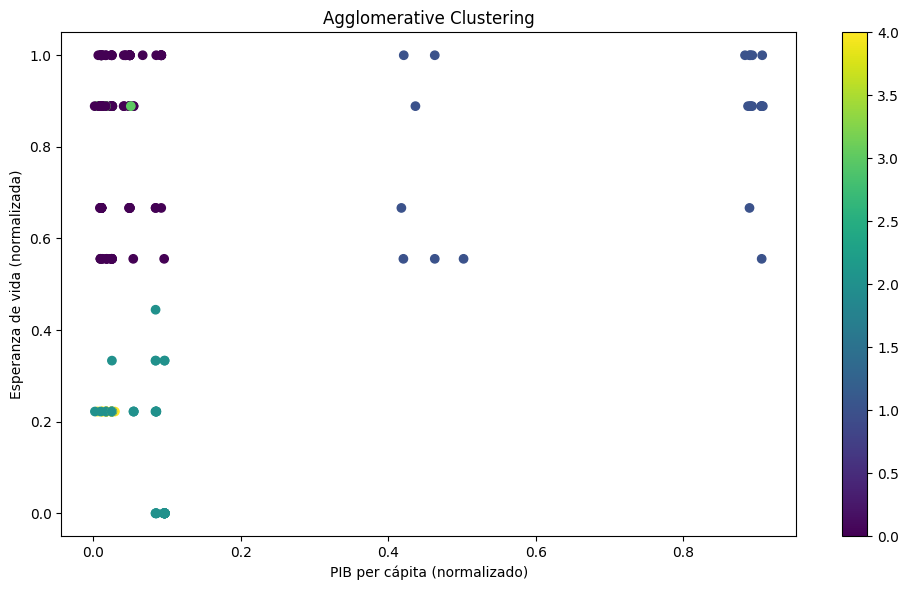

Número de clusters encontrados por Agglomerative Clustering: 5


In [21]:
from sklearn.cluster import AgglomerativeClustering

df_españa = df_filtered[df_filtered['iso_o']=="ESP"]




X = df_españa[['pca_geo_norm', 'famd_trade_norm', 'famd_cult_norm']]
X = np.array(X)

# Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative_labels = agglomerative.fit_predict(X)
# Visualización
fig, ax = plt.subplots(figsize=(10, 6))

# Agglomerative Clustering
scatter = ax.scatter(X[:, 0], X[:, 1], c=agglomerative_labels, cmap='viridis')
ax.set_title('Agglomerative Clustering')
ax.set_xlabel('PIB per cápita (normalizado)')
ax.set_ylabel('Esperanza de vida (normalizada)')
plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

# Imprimir resultados
print("Número de clusters encontrados por Agglomerative Clustering:", len(set(agglomerative_labels)))

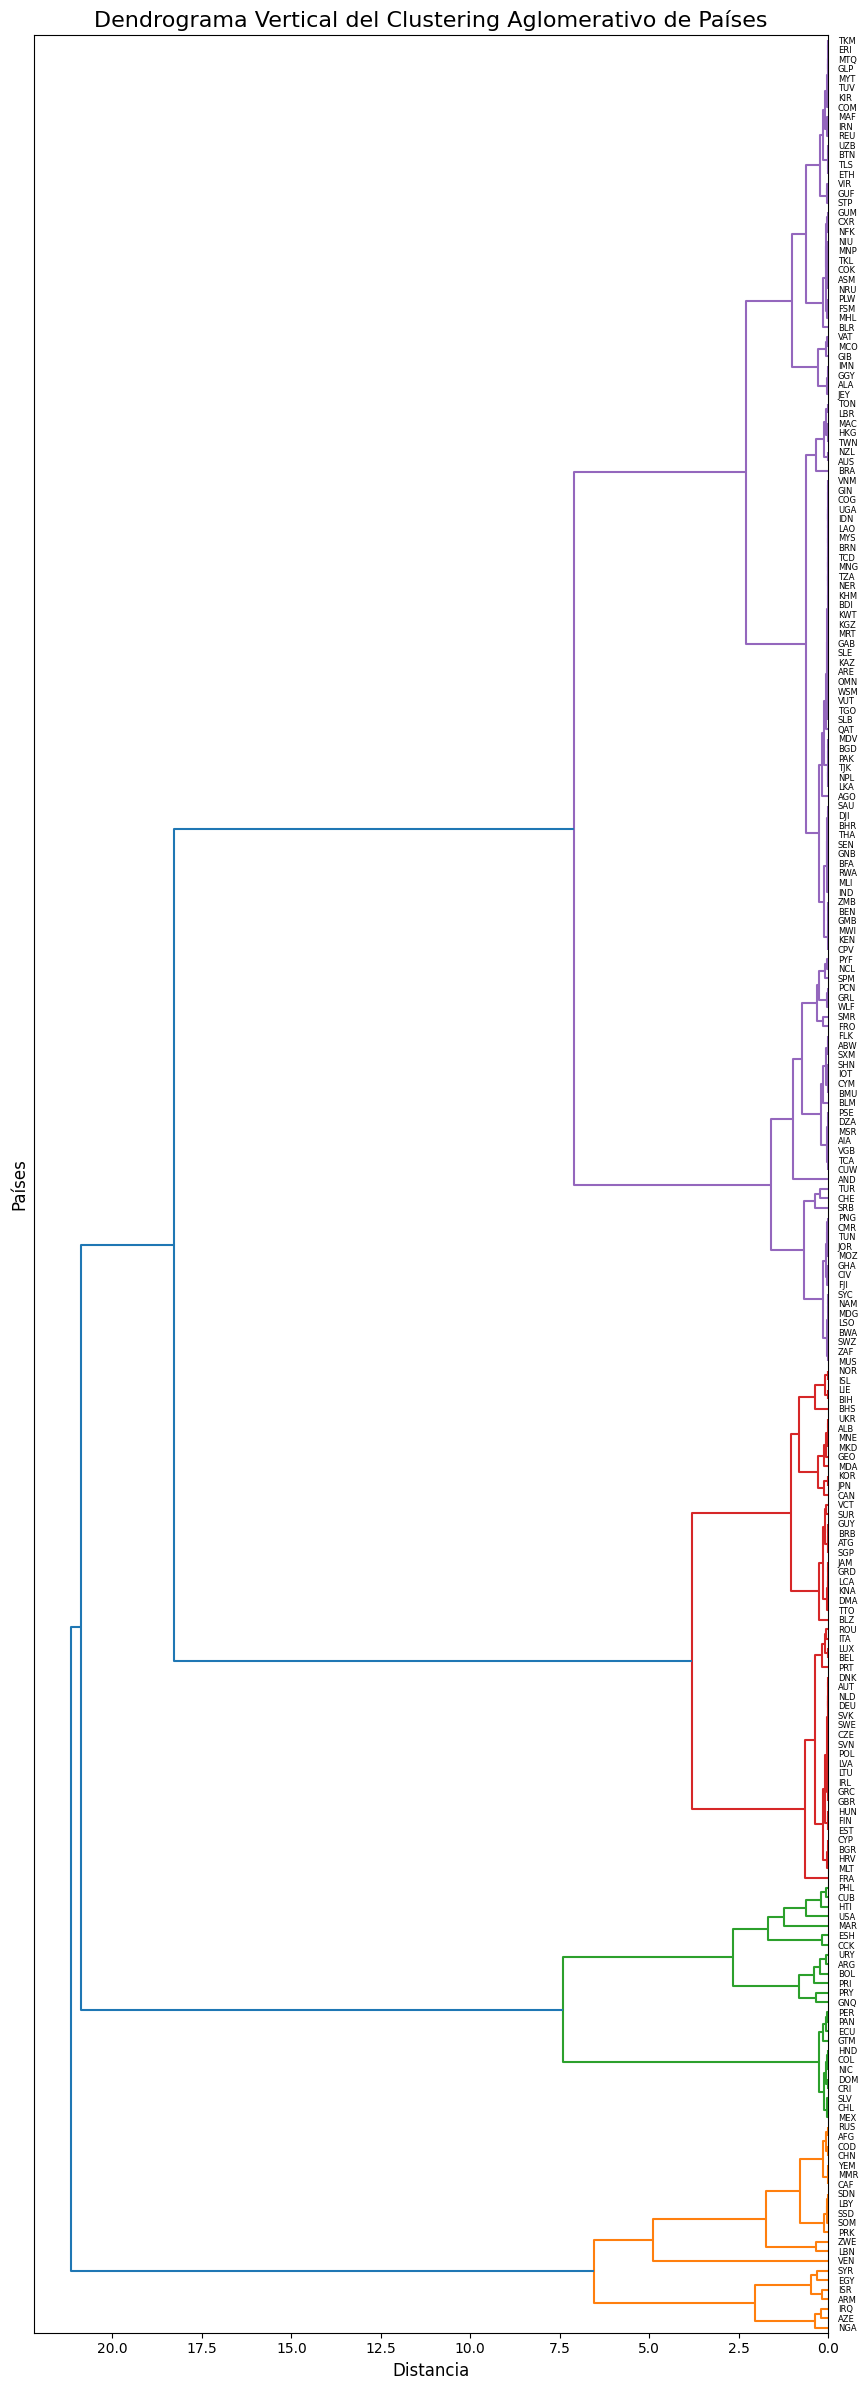

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

# Asumiendo que df_españa ya está definido
X = df_españa[['pca_geo_norm', 'famd_trade_norm', 'famd_cult_norm']].values
country_names = df_españa['iso_d'].tolist()  # Usar códigos ISO de países

# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Crear el linkage matrix para el dendrograma
linkage_matrix = linkage(X_normalized, method='ward')

# Calcular la altura de la figura basada en el número de países
fig_height = max(20, len(country_names) * 0.1)  # Ajusta el factor 0.2 según sea necesario

# Crear la figura para el dendrograma
plt.figure(figsize=(12, fig_height))

# Generar el dendrograma
dendrogram(
    linkage_matrix,
    labels=country_names,
    orientation='left',  # Hacer el dendrograma vertical
    leaf_font_size=6,    # Ajusta este valor si es necesario
    leaf_rotation=0      # Mantener las etiquetas horizontales
)

# Configurar el título y etiquetas
plt.title('Dendrograma Vertical del Clustering Aglomerativo de Países', fontsize=16)
plt.xlabel('Distancia', fontsize=12)
plt.ylabel('Países', fontsize=12)

# Ajustar el layout
plt.tight_layout()

# Ajustar los márgenes para evitar que las etiquetas se corten
plt.subplots_adjust(left=0.3)  # Ajusta este valor si es necesario

# Mostrar la figura
plt.show()

# Opcional: Si quieres guardar la figura
# plt.savefig('dendrograma_vertical_todos_paises.png', dpi=300, bbox_inches='tight')

In [39]:

# Función para imprimir países por cluster
def print_countries_by_cluster(labels, algorithm_name):
    unique_labels = set(labels)
    print(f"\nPaíses por cluster ({algorithm_name}):")
    for label in unique_labels:
        if label != -1:  # -1 es el label para ruido en DBSCAN
            countries = df_españa[labels == label]['iso_d'].tolist()
            print(f"Cluster {label}: {', '.join(countries)}")
        else:
            countries = df_españa[labels == -1]['iso_d'].tolist()
            print(f"Ruido: {', '.join(countries)}")


# Imprimir países por cluster para Agglomerative Clustering
print_countries_by_cluster(agglomerative_labels, "Agglomerative Clustering")


Países por cluster (Agglomerative Clustering):
Cluster 0: ABW, AGO, AIA, ALA, AND, ARE, ASM, AUS, BDI, BEN, BFA, BGD, BHR, BLM, BLR, BMU, BRA, BRN, BTN, BWA, CHE, CIV, CMR, COG, COK, COM, CPV, CUW, CXR, CYM, DJI, DZA, ERI, ETH, FJI, FLK, FRO, FSM, GAB, GGY, GHA, GIB, GIN, GLP, GMB, GNB, GRL, GUF, GUM, HKG, IDN, IMN, IND, IOT, IRN, JEY, JOR, KAZ, KEN, KGZ, KHM, KIR, KWT, LAO, LBR, LKA, LSO, MAC, MAF, MCO, MDG, MDV, MHL, MLI, MNG, MNP, MOZ, MRT, MSR, MTQ, MUS, MWI, MYS, MYT, NAM, NCL, NER, NFK, NIU, NPL, NRU, NZL, OMN, PAK, PCN, PLW, PNG, PSE, PYF, QAT, REU, RWA, SAU, SEN, SHN, SLB, SLE, SMR, SPM, SRB, STP, SWZ, SXM, SYC, TCA, TCD, TGO, THA, TJK, TKL, TKM, TLS, TON, TUN, TUR, TUV, TWN, TZA, UGA, UZB, VAT, VGB, VIR, VNM, VUT, WLF, WSM, ZAF, ZMB
Cluster 1: AFG, ARM, AZE, CAF, CHN, COD, EGY, IRQ, ISR, LBN, LBY, MMR, NGA, PRK, RUS, SDN, SOM, SSD, SYR, VEN, YEM, ZWE
Cluster 2: ARG, BOL, CCK, CUB, ESH, GNQ, HTI, MAR, PHL, PRI, PRY, URY, USA
Cluster 3: ALB, ATG, AUT, BEL, BGR, BHS, BIH, BLZ, B

In [40]:

# Exportar resultados de Agglomerative Clustering a CSV
results_df = pd.DataFrame({
    'iso_d': df_españa['iso_d'],
    'cluster': agglomerative_labels,
    'pca_geo_norm': df_españa['pca_geo_norm'],
    'famd_trade_norm': df_españa['famd_trade_norm'],
    'famd_cult_norm': df_españa['famd_cult_norm']
})

# Ordenar por cluster y luego por iso_d
results_df = results_df.sort_values(['cluster', 'iso_d'])

# Exportar a CSV
results_df.to_csv(r"C:\Users\Usuario\Documents\Github\Seguridad económica\Resultados\comunidades\agglomerative_clustering_results.csv", sep = ";", index=False)
print("\nResultados del Agglomerative Clustering exportados a 'agglomerative_clustering_results.csv'")


Resultados del Agglomerative Clustering exportados a 'agglomerative_clustering_results.csv'


---
### TABLA
---

In [44]:
import pandas as pd
from collections import defaultdict

# Definir los nombres de los clusters
cluster_names = {
    0: "Economías Emergentes y en Desarrollo",
    1: "Estados con Desafíos Geopolíticos",
    2: "Economías Avanzadas y Aliados Estratégicos",
    3: "Socios Históricos y Culturales",
    4: "América Latina: Aliados Regionales Clave"
}

# Asumiendo que results_df es tu DataFrame con la información de clusters
# Si el nombre de tu DataFrame es diferente, cámbialo aquí
df = results_df

# Asegurarse de que las columnas necesarias existen
if 'cluster' not in df.columns or 'iso_d' not in df.columns:
    raise ValueError("El DataFrame debe contener las columnas 'cluster' e 'iso_d'")

# Crear un diccionario para almacenar los países por cluster
clusters = defaultdict(list)

# Agrupar los países por cluster
for _, row in df.iterrows():
    clusters[row['cluster']].append(row['iso_d'])

# Encontrar el número máximo de países en un cluster
max_countries = max(len(countries) for countries in clusters.values())

# Crear un DataFrame con los países organizados por cluster nombrado
cluster_df = pd.DataFrame({
    f"{cluster_names[i]} (Cluster {i})": pd.Series(countries + [''] * (max_countries - len(countries)))
    for i, countries in clusters.items()
})

# Ordenar las columnas por número de cluster
cluster_df = cluster_df.reindex(sorted(cluster_df.columns, key=lambda x: int(x.split()[-1].strip(')'))), axis=1)

# Mostrar la tabla
print(cluster_df.to_string(index=False))

# Guardar la tabla en un archivo CSV (opcional)
cluster_df.to_csv('../Resultados/comunidades/paises_por_cluster_nombrado.csv', index=False, sep=';', encoding='utf-8-sig')

# Imprimir información adicional
print("\nNúmero de países en cada cluster:")
for i, (name, countries) in enumerate(zip(cluster_names.values(), clusters.values())):
    print(f"{name} (Cluster {i}): {len(countries)} países")

Economías Emergentes y en Desarrollo (Cluster 0) Estados con Desafíos Geopolíticos (Cluster 1) Economías Avanzadas y Aliados Estratégicos (Cluster 2) Socios Históricos y Culturales (Cluster 3) América Latina: Aliados Regionales Clave (Cluster 4)
                                             ABW                                           AFG                                                    ARG                                        ALB                                                  CHL
                                             AGO                                           ARM                                                    BOL                                        ATG                                                  COL
                                             AIA                                           AZE                                                    CCK                                        AUT                                                  CRI
                

In [42]:
# Lista de variables a analizar con sus nuevos nombres
variables = {
    'pca_geo_norm': 'Distancia geopolítica',
    'famd_trade_norm': 'Distancia comercial',
    'famd_cult_norm': 'Distancia cultural'
}

# Función para calcular media y desviación estándar
def calc_stats(group):
    return pd.DataFrame({
        'mean': group[variables.keys()].mean(),
        'std': group[variables.keys()].std()
    })

# Calcular estadísticas por cluster
cluster_stats = results_df.groupby('cluster').apply(calc_stats).reset_index()

# Reestructurar los datos
reshaped_stats = []
for cluster in sorted(cluster_stats['cluster'].unique()):
    cluster_data = cluster_stats[cluster_stats['cluster'] == cluster]
    cluster_name = f"{cluster_names[cluster]} (Cluster {cluster})"
    
    mean_row = {'Cluster': cluster_name, 'Estadística': 'Media'}
    std_row = {'Cluster': cluster_name, 'Estadística': 'Desv. Est.'}
    
    for old_var, new_var in variables.items():
        mean_value = cluster_data[cluster_data['level_1'] == old_var]['mean'].values[0]
        std_value = cluster_data[cluster_data['level_1'] == old_var]['std'].values[0]
        
        mean_row[new_var] = f"{mean_value:.2f}"
        std_row[new_var] = f"{std_value:.2f}"
    
    reshaped_stats.extend([mean_row, std_row])

# Crear DataFrame final
final_df = pd.DataFrame(reshaped_stats)

# Reordenar las columnas
column_order = ['Cluster', 'Estadística'] + list(variables.values())
final_df = final_df[column_order]

# Mostrar la tabla
print("\nTabla final:")
print(final_df.to_string(index=False))

# Guardar la tabla en un archivo CSV
final_df.to_csv('../Resultados/comunidades/estadisticas_por_cluster_restructurado.csv', index=False, sep=";", encoding='utf-8-sig')

# Imprimir información adicional
print("\nNúmero de países en cada cluster:")
for cluster, name in cluster_names.items():
    count = len(results_df[results_df['cluster'] == cluster])
    print(f"{name} (Cluster {cluster}): {count} países")


Tabla final:
                                               Cluster Estadística Distancia geopolítica Distancia comercial Distancia cultural
      Economías Emergentes y en Desarrollo (Cluster 0)       Media                  0.03                0.83               0.99
      Economías Emergentes y en Desarrollo (Cluster 0)  Desv. Est.                  0.02                0.16               0.02
         Estados con Desafíos Geopolíticos (Cluster 1)       Media                  0.75                0.84               0.96
         Estados con Desafíos Geopolíticos (Cluster 1)  Desv. Est.                  0.22                0.17               0.16
Economías Avanzadas y Aliados Estratégicos (Cluster 2)       Media                  0.02                0.90               0.43
Economías Avanzadas y Aliados Estratégicos (Cluster 2)  Desv. Est.                  0.02                0.12               0.13
            Socios Históricos y Culturales (Cluster 3)       Media                  0.07  

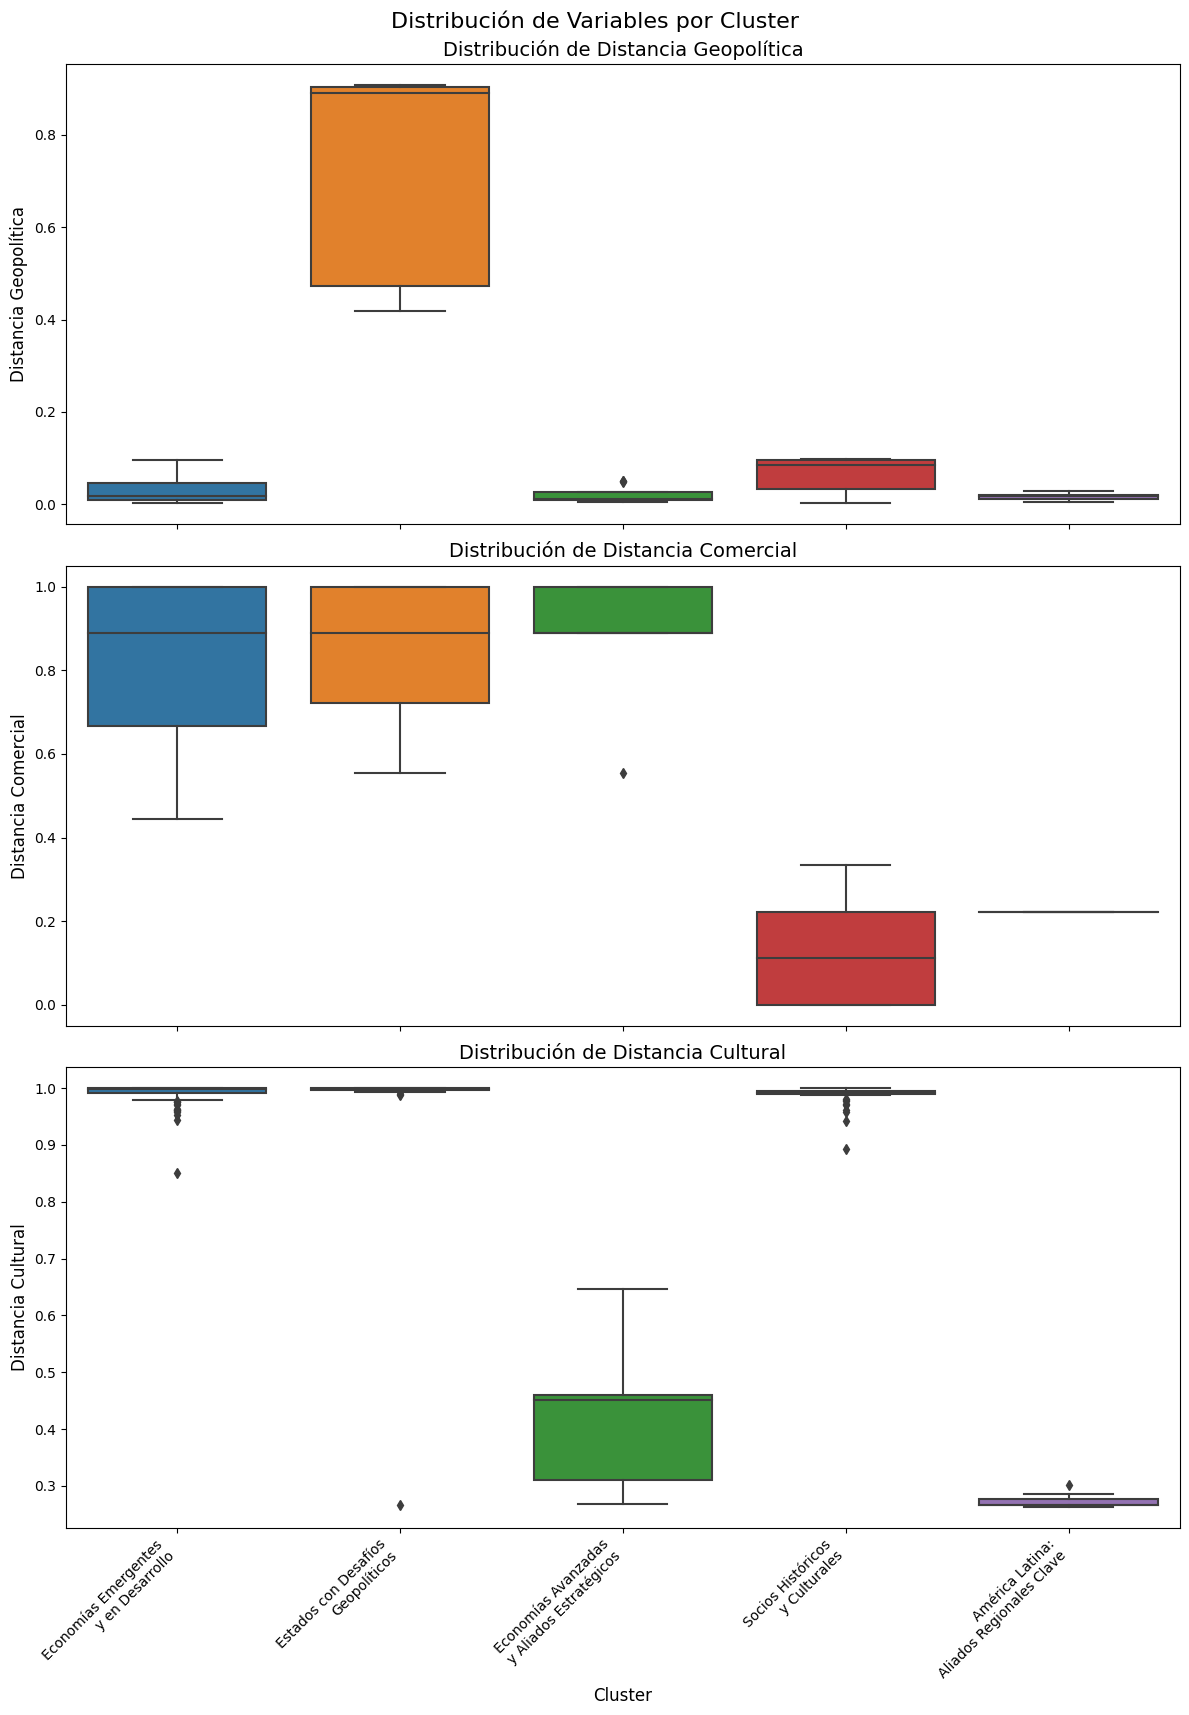

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que ya tienes tu dataframe results_df

# Definir nombres más descriptivos para las variables
variable_names = {
    'pca_geo_norm': 'Distancia Geopolítica',
    'famd_trade_norm': 'Distancia Comercial',
    'famd_cult_norm': 'Distancia Cultural'
}

# Definir nombres para los clusters
cluster_names = {
    0: "Economías Emergentes\ny en Desarrollo",
    1: "Estados con Desafíos\nGeopolíticos",
    2: "Economías Avanzadas\ny Aliados Estratégicos",
    3: "Socios Históricos\ny Culturales",
    4: "América Latina:\nAliados Regionales Clave"
}

# Crear una figura con 3 subplots, uno para cada variable
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Agregar un título principal
fig.suptitle('Distribución de Variables por Cluster', fontsize=16, y=0.95)

# Lista de variables para los boxplots
variables = ['pca_geo_norm', 'famd_trade_norm', 'famd_cult_norm']

# Crear un boxplot para cada variable
for i, var in enumerate(variables):
    sns.boxplot(x='cluster', y=var, data=results_df, ax=axs[i])
    axs[i].set_title(f'Distribución de {variable_names[var]}', fontsize=14)
    axs[i].set_ylabel(variable_names[var], fontsize=12)
    
    # Configurar las etiquetas del eje x
    if i < 2:  # Para los dos primeros gráficos
        axs[i].set_xticklabels([''] * 5)
        axs[i].set_xlabel('')
    else:  # Para el último gráfico
        axs[i].set_xticklabels([cluster_names[j] for j in range(5)], rotation=45, ha='right')
        axs[i].set_xlabel('Cluster', fontsize=12)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Ajustar el espacio para el título principal
plt.subplots_adjust(top=0.92)

# Mostrar la figura
plt.show()

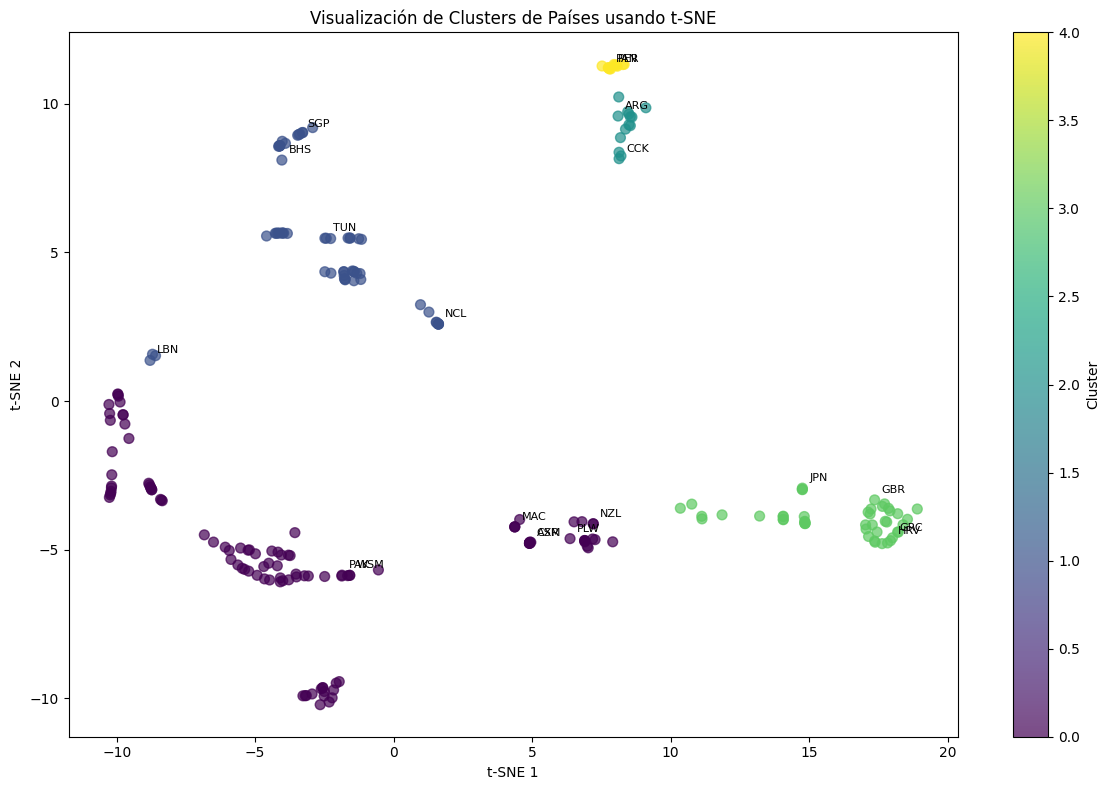

Número de países en la visualización: 240
Número de clusters únicos: 5
Rango de valores para TSNE1: -10.28 a 18.91
Rango de valores para TSNE2: -10.22 a 11.33


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Asumiendo que ya tienes tu dataframe results_df

# Seleccionar las variables para el análisis
features = ['pca_geo_norm', 'famd_trade_norm', 'famd_cult_norm']

# Asegurarse de que no hay valores faltantes en las características
results_df_clean = results_df.dropna(subset=features + ['cluster', 'iso_d'])

# Estandarizar las características
scaler = StandardScaler()
scaled_features = scaler.fit_transform(results_df_clean[features])

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)

# Crear un nuevo dataframe con los resultados de t-SNE
df_tsne = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'], index=results_df_clean.index)
df_tsne['Cluster'] = results_df_clean['cluster']
df_tsne['Country'] = results_df_clean['iso_d']

# Crear el gráfico
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], 
                      c=df_tsne['Cluster'], cmap='viridis', 
                      alpha=0.7, s=50)

# Añadir etiquetas para algunos países (puedes ajustar esto según tus necesidades)
for i, txt in enumerate(df_tsne['Country']):
    if np.random.rand() < 0.1:  # Etiqueta aleatoriamente el 10% de los países
        plt.annotate(txt, (df_tsne['TSNE1'].iloc[i], df_tsne['TSNE2'].iloc[i]), xytext=(5,5), 
                     textcoords='offset points', fontsize=8)

plt.colorbar(scatter, label='Cluster')
plt.title('Visualización de Clusters de Países usando t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

# Imprimir información sobre los datos
print(f"Número de países en la visualización: {len(df_tsne)}")
print(f"Número de clusters únicos: {df_tsne['Cluster'].nunique()}")
print(f"Rango de valores para TSNE1: {df_tsne['TSNE1'].min():.2f} a {df_tsne['TSNE1'].max():.2f}")
print(f"Rango de valores para TSNE2: {df_tsne['TSNE2'].min():.2f} a {df_tsne['TSNE2'].max():.2f}")

In [1]:
import pandas as pd

def crear_tabla_clusters():
    """
    Crea una tabla formateada de clusters de países con su información correspondiente.
    
    Returns:
        tuple: (df_clusters, styled_df)
            - df_clusters: DataFrame con la información básica
            - styled_df: DataFrame con estilos aplicados para mejor visualización
    """
    # Definir los clusters y sus países
    clusters = {
        'Economías Emergentes y en Desarrollo (Cluster 0)': [
            'ABW', 'AGO', 'AIA', 'ALA', 'AND', 'ARE', 'ASM', 'AUS', 'BDI', 'BEN',
            'BFA', 'BGD', 'BHR', 'BLM', 'BLR', 'BMU', 'BRA', 'BRN', 'BTN', 'BWA',
            'CHE', 'CIV', 'CMR', 'COG'
        ],
        'Estados con Desafíos Geopolíticos (Cluster 1)': [
            'AFG', 'ARM', 'AZE', 'CAF', 'CHN', 'COD', 'EGY', 'IRQ', 'ISR', 'LBN',
            'LBY', 'MMR', 'NGA', 'PRK', 'RUS', 'SDN', 'SOM', 'SSD', 'SYR', 'VEN',
            'YEM', 'ZWE'
        ],
        'Economías Avanzadas y Aliados Estratégicos (Cluster 2)': [
            'ARG', 'BOL', 'CCK', 'CUB', 'ESH', 'GNQ', 'HTI', 'MAR', 'PHL', 'PRI',
            'PRY', 'URY', 'USA'
        ],
        'Socios Históricos y Culturales (Cluster 3)': [
            'ALB', 'ATG', 'AUT', 'BEL', 'BGR', 'BHS', 'BIH', 'BLZ', 'BRB', 'CAN',
            'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'EST', 'FIN', 'FRA', 'GBR', 'GEO',
            'GRC', 'GRD', 'GUY', 'HRV'
        ],
        'América Latina: Aliados Regionales Clave (Cluster 4)': [
            'CHL', 'COL', 'CRI', 'DOM', 'ECU', 'GTM', 'HND', 'MEX', 'NIC', 'PAN',
            'PER', 'SLV'
        ]
    }

    # Crear un DataFrame con la información
    df_clusters = pd.DataFrame({
        'Cluster': [],
        'Países': [],
        'Número de Países': []
    })

    # Llenar el DataFrame
    for cluster, paises in clusters.items():
        df_clusters = df_clusters._append({
            'Cluster': cluster,
            'Países': ', '.join(sorted(paises)),
            'Número de Países': len(paises)
        }, ignore_index=True)

    # Formatear la tabla
    pd.set_option('display.max_colwidth', None)
    styled_df = df_clusters.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#f0f0f0')]},
        {'selector': 'td', 'props': [('padding', '10px')]},
    ])

    # Mostrar resumen
    print("\nResumen de Clusters:")
    for cluster in df_clusters['Cluster']:
        print(f"{cluster}: {df_clusters[df_clusters['Cluster'] == cluster]['Número de Países'].values[0]} países")

    return df_clusters, styled_df

# Ejemplo de uso
if __name__ == "__main__":
    df, styled_df = crear_tabla_clusters()
    print("\nDataFrame sin estilo:")
    print(df)
    print("\nPara ver el DataFrame estilizado, usar en un notebook:")
    print("display(styled_df)")

c:\Users\Usuario\anaconda3\envs\tftimeseries\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Usuario\anaconda3\envs\tftimeseries\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (



Resumen de Clusters:
Economías Emergentes y en Desarrollo (Cluster 0): 24.0 países
Estados con Desafíos Geopolíticos (Cluster 1): 22.0 países
Economías Avanzadas y Aliados Estratégicos (Cluster 2): 13.0 países
Socios Históricos y Culturales (Cluster 3): 24.0 países
América Latina: Aliados Regionales Clave (Cluster 4): 12.0 países

DataFrame sin estilo:
                                                  Cluster  \
0        Economías Emergentes y en Desarrollo (Cluster 0)   
1           Estados con Desafíos Geopolíticos (Cluster 1)   
2  Economías Avanzadas y Aliados Estratégicos (Cluster 2)   
3              Socios Históricos y Culturales (Cluster 3)   
4    América Latina: Aliados Regionales Clave (Cluster 4)   

                                                                                                                   Países  \
0  ABW, AGO, AIA, ALA, AND, ARE, ASM, AUS, BDI, BEN, BFA, BGD, BHR, BLM, BLR, BMU, BRA, BRN, BTN, BWA, CHE, CIV, CMR, COG   
1            AFG, ARM, AZE,

In [2]:
df, styled_df = crear_tabla_clusters()

# Para ver la tabla normal
print(df)

# Para ver la tabla estilizada en un notebook
from IPython.display import display
display(styled_df)

# Para acceder a datos específicos
print(f"Número de clusters: {len(df)}")
print(f"Total de países: {df['Número de Países'].sum()}")


Resumen de Clusters:
Economías Emergentes y en Desarrollo (Cluster 0): 24.0 países
Estados con Desafíos Geopolíticos (Cluster 1): 22.0 países
Economías Avanzadas y Aliados Estratégicos (Cluster 2): 13.0 países
Socios Históricos y Culturales (Cluster 3): 24.0 países
América Latina: Aliados Regionales Clave (Cluster 4): 12.0 países
                                                  Cluster  \
0        Economías Emergentes y en Desarrollo (Cluster 0)   
1           Estados con Desafíos Geopolíticos (Cluster 1)   
2  Economías Avanzadas y Aliados Estratégicos (Cluster 2)   
3              Socios Históricos y Culturales (Cluster 3)   
4    América Latina: Aliados Regionales Clave (Cluster 4)   

                                                                                                                   Países  \
0  ABW, AGO, AIA, ALA, AND, ARE, ASM, AUS, BDI, BEN, BFA, BGD, BHR, BLM, BLR, BMU, BRA, BRN, BTN, BWA, CHE, CIV, CMR, COG   
1            AFG, ARM, AZE, CAF, CHN, COD, EGY, IR

,Cluster,Países,Número de Países
0,Economías Emergentes y en Desarrollo (Cluster 0),"ABW, AGO, AIA, ALA, AND, ARE, ASM, AUS, BDI, BEN, BFA, BGD, BHR, BLM, BLR, BMU, BRA, BRN, BTN, BWA, CHE, CIV, CMR, COG",24.000000
1,Estados con Desafíos Geopolíticos (Cluster 1),"AFG, ARM, AZE, CAF, CHN, COD, EGY, IRQ, ISR, LBN, LBY, MMR, NGA, PRK, RUS, SDN, SOM, SSD, SYR, VEN, YEM, ZWE",22.000000
2,Economías Avanzadas y Aliados Estratégicos (Cluster 2),"ARG, BOL, CCK, CUB, ESH, GNQ, HTI, MAR, PHL, PRI, PRY, URY, USA",13.000000
3,Socios Históricos y Culturales (Cluster 3),"ALB, ATG, AUT, BEL, BGR, BHS, BIH, BLZ, BRB, CAN, CYP, CZE, DEU, DMA, DNK, EST, FIN, FRA, GBR, GEO, GRC, GRD, GUY, HRV",24.000000
4,América Latina: Aliados Regionales Clave (Cluster 4),"CHL, COL, CRI, DOM, ECU, GTM, HND, MEX, NIC, PAN, PER, SLV",12.000000


Número de clusters: 5
Total de países: 95.0


In [3]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def crear_visualizacion_clusters():
    """
    Crea visualizaciones interactivas de los clusters de países.
    """
    # Definir los clusters y sus países
    clusters = {
        'Economías Emergentes y en Desarrollo': [
            'ABW', 'AGO', 'AIA', 'ALA', 'AND', 'ARE', 'ASM', 'AUS', 'BDI', 'BEN',
            'BFA', 'BGD', 'BHR', 'BLM', 'BLR', 'BMU', 'BRA', 'BRN', 'BTN', 'BWA',
            'CHE', 'CIV', 'CMR', 'COG'
        ],
        'Estados con Desafíos Geopolíticos': [
            'AFG', 'ARM', 'AZE', 'CAF', 'CHN', 'COD', 'EGY', 'IRQ', 'ISR', 'LBN',
            'LBY', 'MMR', 'NGA', 'PRK', 'RUS', 'SDN', 'SOM', 'SSD', 'SYR', 'VEN',
            'YEM', 'ZWE'
        ],
        'Economías Avanzadas y Aliados Estratégicos': [
            'ARG', 'BOL', 'CCK', 'CUB', 'ESH', 'GNQ', 'HTI', 'MAR', 'PHL', 'PRI',
            'PRY', 'URY', 'USA'
        ],
        'Socios Históricos y Culturales': [
            'ALB', 'ATG', 'AUT', 'BEL', 'BGR', 'BHS', 'BIH', 'BLZ', 'BRB', 'CAN',
            'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'EST', 'FIN', 'FRA', 'GBR', 'GEO',
            'GRC', 'GRD', 'GUY', 'HRV'
        ],
        'América Latina: Aliados Regionales Clave': [
            'CHL', 'COL', 'CRI', 'DOM', 'ECU', 'GTM', 'HND', 'MEX', 'NIC', 'PAN',
            'PER', 'SLV'
        ]
    }

    # Crear DataFrame para el treemap
    data = []
    for cluster, paises in clusters.items():
        for pais in paises:
            data.append({
                'Cluster': cluster,
                'País': pais,
                'Valor': 1  # Cada país tiene el mismo peso
            })
    
    df = pd.DataFrame(data)

    # Crear treemap
    fig_treemap = px.treemap(
        df,
        path=[px.Constant("Todos los Clusters"), 'Cluster', 'País'],
        values='Valor',
        color='Cluster',
        color_discrete_sequence=px.colors.qualitative.Set3,
        title='Distribución de Países por Cluster'
    )

    # Personalizar el diseño
    fig_treemap.update_layout(
        title_x=0.5,
        title_font_size=24,
        width=1200,
        height=800,
        font=dict(size=14),
    )

    # Crear gráfico de barras para mostrar el tamaño de los clusters
    cluster_sizes = df.groupby('Cluster').size()
    
    fig_bars = go.Figure()
    
    fig_bars.add_trace(go.Bar(
        x=cluster_sizes.index,
        y=cluster_sizes.values,
        marker_color=px.colors.qualitative.Set3,
        text=cluster_sizes.values,
        textposition='auto',
    ))

    fig_bars.update_layout(
        title={
            'text': 'Número de Países por Cluster',
            'x': 0.5,
            'y': 0.95,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24)
        },
        xaxis_title="Cluster",
        yaxis_title="Número de Países",
        width=1200,
        height=600,
        showlegend=False,
        xaxis_tickangle=-45,
        font=dict(size=14),
        margin=dict(t=100, l=100, r=100, b=100)
    )

    # Crear gráfico circular
    fig_pie = px.pie(
        df,
        names='Cluster',
        title='Distribución Porcentual de Países por Cluster',
        color='Cluster',
        color_discrete_sequence=px.colors.qualitative.Set3,
    )

    fig_pie.update_layout(
        title_x=0.5,
        title_font_size=24,
        width=1000,
        height=700,
        font=dict(size=14),
        showlegend=True,
        legend=dict(orientation="h", y=-0.1)
    )

    return fig_treemap, fig_bars, fig_pie

# Ejemplo de uso
if __name__ == "__main__":
    fig_treemap, fig_bars, fig_pie = crear_visualizacion_clusters()
    
    # Para mostrar en notebook
    # fig_treemap.show()
    # fig_bars.show()
    # fig_pie.show()
    
    # Para guardar como HTML interactivo
    fig_treemap.write_html("clusters_treemap.html")
    fig_bars.write_html("clusters_bars.html")
    fig_pie.write_html("clusters_pie.html")

In [4]:
# Crear las visualizaciones
fig_treemap, fig_bars, fig_pie = crear_visualizacion_clusters()

# En un notebook de Jupyter
fig_treemap.show()
fig_bars.show()
fig_pie.show()

# O guardar como archivos HTML interactivos
fig_treemap.write_html("clusters_treemap.html")
fig_bars.write_html("clusters_bars.html")
fig_pie.write_html("clusters_pie.html")